# Mechanics Applications in FEniCS

In [2]:
%matplotlib inline

## Time-dependent problems: diffusion

Recall the Poisson equation

$$- \nabla^2 u(\boldsymbol{x}) = f(\boldsymbol{x})) \qquad \text{on } \Omega$$

augmented by some Dirichlet boundary conditions

$$u(\boldsymbol{x}) = u_D(\boldsymbol{x}) \qquad \text{on } \partial \Omega$$.

The Poisson equation is a stationary problem (no time dependence). However, in mechanics applications and for biological systems in particular, we are most often interested in solving time-dependent problems. The Poisson equation can easily be extended to a time-dependent problem by introducing time as variable $t$, resulting in the diffusion (or heat) equation:

$$\frac{\partial u(t, \boldsymbol{x})}{\partial t} = \nabla^2 u(t, \boldsymbol{x}) + f(t, \boldsymbol{x}) \qquad \text{on } \Omega$$
$$u(t, \boldsymbol{x}) = u_D(t, \boldsymbol{x}) \qquad \text{on } \partial \Omega$$
$$u(t, \boldsymbol{x}) = u_0(\boldsymbol{x}) \qquad \text{at } t = 0$$

Now, the solution $u(t, \boldsymbol{x})$ and source function $f(t, \boldsymbol{x})$ vary with both space and time. For convenience we from now on write $u = u(t, \boldsymbol{x})$, etc. Note that in order to solve this time-dependent problem we now also require an initial condition $u_0(\boldsymbol{x})$.

### Discretisation

To obtain the variational form of the diffusion equation we have to first discretise the time-dependent term using a finite difference scheme. For simplicity we choose the simple backwar Euler method:

$$\frac{\partial u}{\partial t} \approx \frac{u^{n+1} + u^n}{\Delta t}$$

with current time step $n$ and discrete time step size $\Delta t$. The diffusion equation now reads 

$$\frac{u^{n+1} + u^n}{\Delta t} = \nabla^2 u^{n+1} + f^{n+1} \qquad \text{on } \Omega$$

Recall the variational form of the Poisson equation: Given trial and test spaces $V$ and $\hat{V}$, find $u \in V$ such that

$$\int_{\Omega} \nabla u \cdot \nabla v dx = \int_{\Omega} fv dx \qquad \forall v \in \hat{V}$$

To obtain the variational form for the diffusion equation we just need to add the time-discretised term:

$$\int_{\Omega} \frac{u^{n+1} + u^n}{\Delta t} v dx - \int_{\Omega} \nabla u \cdot \nabla v dx - \int_{\Omega} fv dx = 0\qquad \forall v \in \hat{V}$$

### FEniCS implementation

t = 0.10; error = 0.0116; relative error = 0.0104
t = 0.20; error = 0.0116; relative error = 0.00937
t = 0.30; error = 0.0116; relative error = 0.00855
t = 0.40; error = 0.0116; relative error = 0.00785
t = 0.50; error = 0.0116; relative error = 0.00727
t = 0.60; error = 0.0116; relative error = 0.00676
t = 0.70; error = 0.0116; relative error = 0.00632
t = 0.80; error = 0.0116; relative error = 0.00593
t = 0.90; error = 0.0116; relative error = 0.00559
t = 1.00; error = 0.0116; relative error = 0.00528
t = 1.10; error = 0.0116; relative error = 0.00501
t = 1.20; error = 0.0116; relative error = 0.00476
t = 1.30; error = 0.0116; relative error = 0.00454
t = 1.40; error = 0.0116; relative error = 0.00434
t = 1.50; error = 0.0116; relative error = 0.00415
t = 1.60; error = 0.0116; relative error = 0.00398
t = 1.70; error = 0.0116; relative error = 0.00382
t = 1.80; error = 0.0116; relative error = 0.00368
t = 1.90; error = 0.0116; relative error = 0.00354
t = 2.00; error = 0.0116; relati

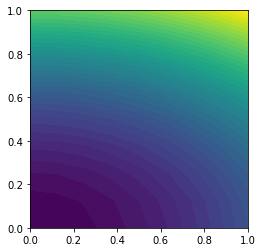

In [17]:
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 20     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)
V2 = FunctionSpace(mesh, 'P', 2)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = interpolate(u_D, V2)
    u_ee = project(u_e, V)
    error = np.abs(u_ee.vector().get_local() - u.vector().get_local()).max()
    rel_error = np.abs((u_ee.vector().get_local() - u.vector().get_local())/u.vector().get_local()).max()
    print('t = %.2f; error = %.3g; relative error = %.3g' % (t, error, rel_error))

    # Update previous solution
    u_n.assign(u)